In [1]:
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv("mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
input_data=df.drop('class',axis=1)
X=pd.get_dummies(input_data,drop_first=True)
y=pd.get_dummies(df["class"],drop_first=True)

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=101)

### XG boost (default parameters)

In [6]:
from xgboost import XGBClassifier
xgb_model=XGBClassifier()
xgb_model.fit(X_train,y_train)

#Prediction
ypred_train=xgb_model.predict(X_train)
ypred_test=xgb_model.predict(X_test)

#Evaluation
#1.Train & test accuracy
from sklearn.metrics import accuracy_score
print("Train accuracy",accuracy_score(y_train,ypred_train))
print("Test accuracy",accuracy_score(y_test,ypred_test))

#2.Cross Validation Score
from sklearn.model_selection import cross_val_score
scores=cross_val_score(xgb_model,X=X,y=y,cv=5)
print("cross validation score:",scores.mean())

Train accuracy 1.0
Test accuracy 1.0
cross validation score: 0.9335172413793102


### hyper parameter tuning

In [7]:
from sklearn.model_selection import GridSearchCV

estimator=XGBClassifier()

param_grid={'n_estimators':[10,20,40,100],
            'max_depth':[3,4,5],
            'gamma':[0,0.15,0.3,0.5,1]}

grid=GridSearchCV(xgb_model,param_grid,cv=5,scoring='accuracy')
grid.fit(X_train,y_train)
grid.best_params_

{'gamma': 0, 'max_depth': 3, 'n_estimators': 40}

### Feature imp

In [8]:
grid.best_estimator_.feature_importances_

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.6167567e-05, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.3581199e-04,
       7.4817427e-03, 6.0288999e-02, 3.3926319e-03, 2.6485398e-02,
       7.9572327e-02, 3.7501424e-03, 2.8154403e-01, 1.7742589e-02,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 8.0583990e-03,
       1.5913136e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       2.4226676e-04, 0.0000000e+00, 2.4518545e-01, 3.0659849e-06,
       1.7321397e-01, 2.1638423e-03, 1.1198281e-04, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 2.0072298e-02, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [9]:
feats=pd.DataFrame(index=X.columns,
                   data=grid.best_estimator_.feature_importances_,
                  columns=['Importance'])
important_features=feats[feats['Importance']>0.01]
imp_features_list=feats[feats['Importance']>0.01].index.to_list()
imp_features_list

['bruises_t',
 'odor_f',
 'odor_l',
 'odor_n',
 'odor_p',
 'gill-size_n',
 'stalk-root_c',
 'stalk-root_r',
 'stalk-surface-below-ring_y',
 'stalk-color-below-ring_y',
 'spore-print-color_r']

### Xgboost with best hyper parameter

In [10]:
X_imp=X[imp_features_list]    #dropped unimp features

X_train,X_test,y_train,y_test= train_test_split(X_imp,y,test_size=0.2,random_state=101)

xgb_bhp=XGBClassifier(gamma=0,max_depth=3,n_estimators=40)
xgb_bhp.fit(X_train,y_train)

ypred_train=xgb_bhp.predict(X_train)
predictions=xgb_bhp.predict(X_test)

from sklearn.metrics import accuracy_score
print("Train_accuracy:",accuracy_score(y_train,ypred_train))
print("Test_accuracy:",accuracy_score(y_test,predictions))

scores=cross_val_score(xgb_bhp,X,y,cv=5)
print("Cross validation score:", scores.mean())

Train_accuracy: 0.9990767810432374
Test_accuracy: 0.9987692307692307
Cross validation score: 0.9092563849943162


### confusion  matrix

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[851,   0],
       [  2, 772]], dtype=int64)

### classification report

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       851
           1       1.00      1.00      1.00       774

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



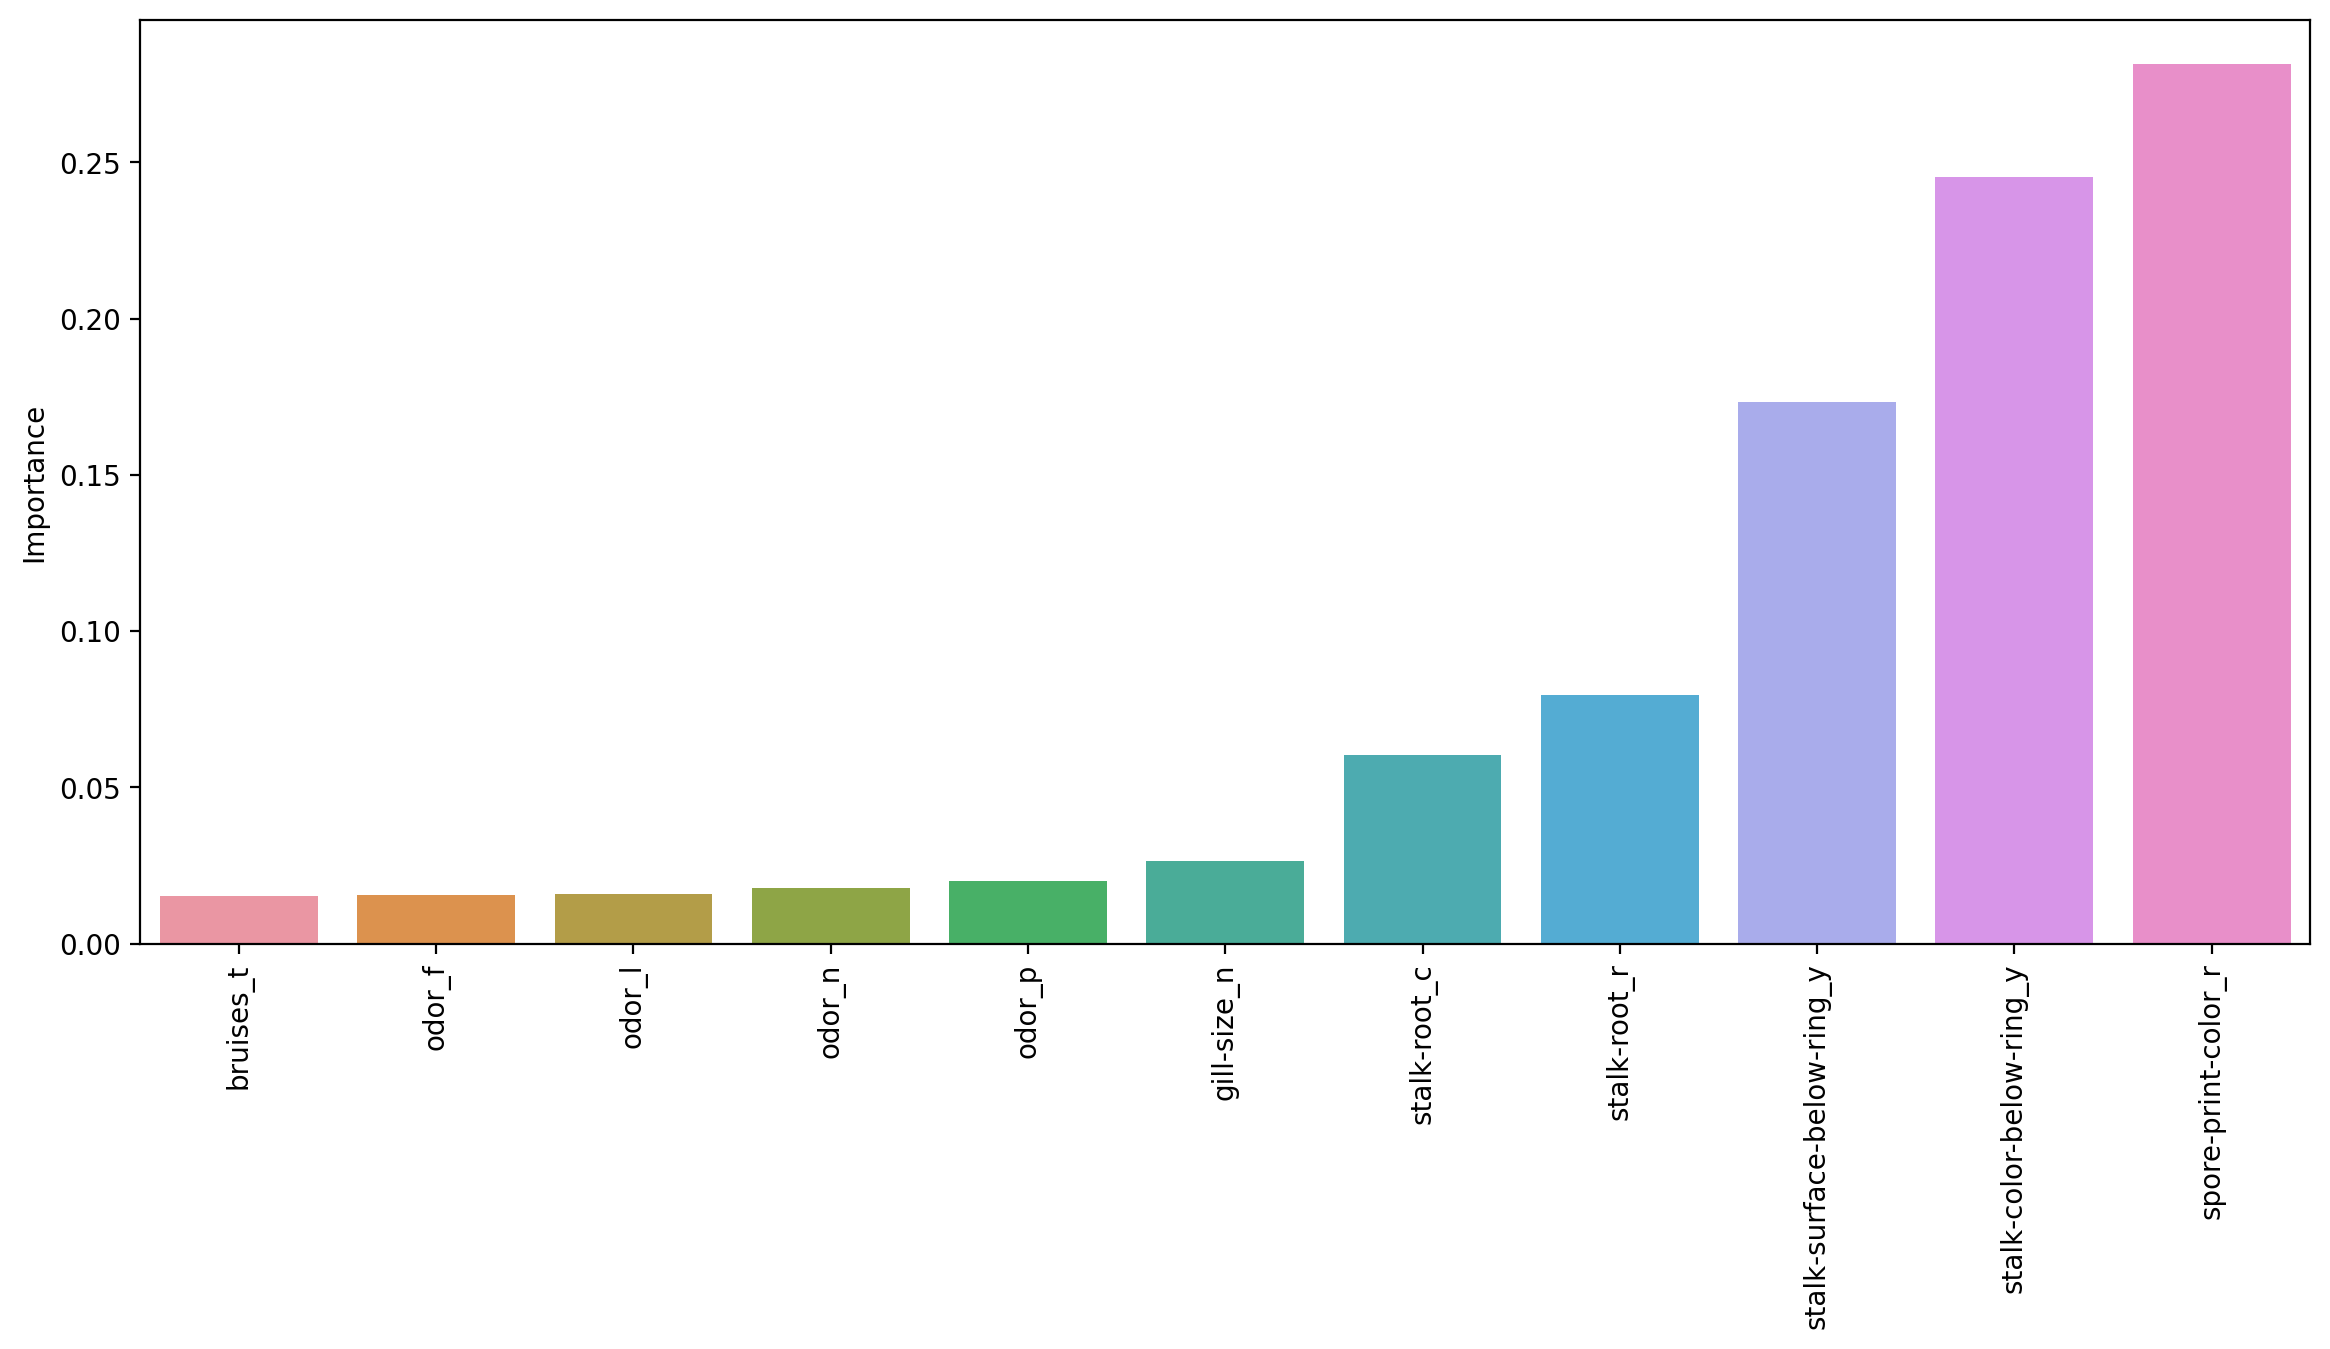

In [13]:
plt.figure(figsize=(14,6),dpi=200)

sns.barplot(data=important_features.sort_values('Importance'),
           x=important_features.index,
           y='Importance')
plt.xticks(rotation=90)
plt.show()